In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
from functools import lru_cache
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import svm
import warnings
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import ValidationCurve

import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

In [2]:
@lru_cache(maxsize=None)
def load_heart():
    # https://www.kaggle.com/ronitf/heart-disease-uci
    df = pd.read_csv("data/heart.csv")
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y

In [3]:
@lru_cache(maxsize=None)
def load_mobile():
    # https://www.kaggle.com/iabhishekofficial/mobile-price-classification
    df = pd.read_csv("data/phone_price.csv")
    print(df['price_range'])
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y

In [4]:
@lru_cache(maxsize=None)
def load_adult():
    df = pd.read_csv("data/adult.csv")
    df = pd.get_dummies(df)
    df = df.drop(df.columns[-2], axis=1)
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y

In [5]:
@lru_cache(maxsize=None)
def load_weather():
    # https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv
    df = pd.read_csv("data/weather.csv")
    df = df.dropna(axis=0)
    df = pd.get_dummies(df, dummy_na=False)
    # drop the nan column
    df = df.drop(df.columns[-1], axis=1)
    # drop the no column
    df = df.drop(df.columns[-2], axis=1)
    X = df.iloc[:,0:-1]
    y = df.iloc[:,-1]
    return X, y


In [6]:
# X, y = load_heart()
X, y = load_mobile()
# X, y = load_adult()
# X, y = load_weather()



0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64


# Understanding the Data

In [7]:
def save_figs(dX, y, name):
    plt.matshow(X.corr())
    plt.yticks(np.arange(X.shape[1]), X.columns)
    plt.xticks(np.arange(X.shape[1]), X.columns)
    plt.colorbar()
    plt.savefig(f'{name}_correlation.png', bbox_inches='tight')
    plt.clf()
    X.hist()
    plt.savefig(f'{name}_histogram.png', bbox_inches='tight')
    plt.clf()
    y.hist()
    plt.savefig(f'{name}_y_histogram.png', bbox_inches='tight')
    plt.clf()
# save_figs(X,y,"weather")

# Generate Train and Test Data

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)


# Decision Tree

(1800, 20)
(2000, 20)


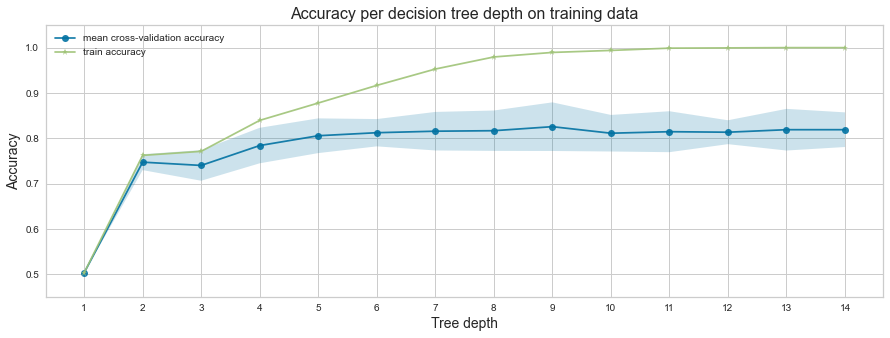

In [38]:
print(x_train.shape)
print(X.shape)
# function for fitting trees of various depths on the training data using cross-validation
# Referenced via https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        fitted = tree_model.fit(X, y)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(fitted.score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim(0.45,1.05)
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,15)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(x_train, y_train, sm_tree_depths)

# plotting accuracy\
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')


# After looking at the graph, looks like a good depth is 4
best_dt_depth = 4
# Empty array that will hold our classifiers
classifiers = []

# MLP (Neural Network)

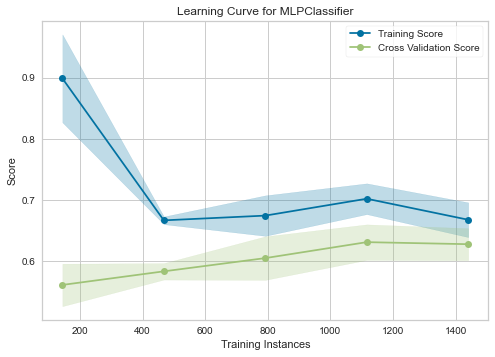

accuracy: 0.640%


In [35]:
mlp = MLPClassifier(max_iter=800)
# Create the learning curve visualizer
visualizer = LearningCurve(
    mlp
)

visualizer.fit(x_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

mlp.fit(x_train,y_train)
accuracy = mlp.score(x_test,y_test)

print("accuracy: {0:.3f}%".format(accuracy))


# Boosting

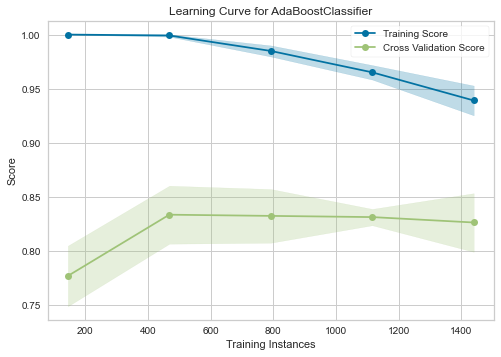

accuracy: 0.835%


In [39]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_dt_depth))
# Create the learning curve visualizer
visualizer = LearningCurve(
    clf
)

visualizer.fit(x_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

clf.fit(x_train,y_train)
accuracy = clf.score(x_test,y_test)

print("accuracy: {0:.3f}%".format(accuracy))

# Support Vector Machines

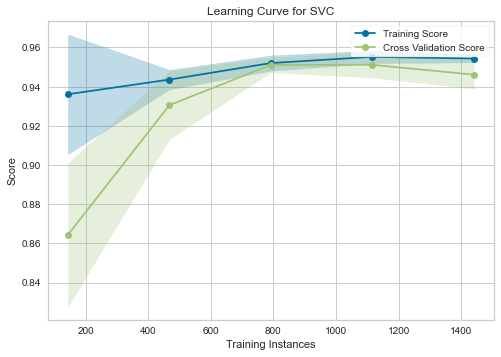

accuracy: 0.940%


In [40]:
clf = svm.SVC()
# Create the learning curve visualizer
visualizer = LearningCurve(
    clf
)

visualizer.fit(x_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

clf.fit(x_train,y_train)
accuracy = clf.score(x_test,y_test)

print("accuracy: {0:.3f}%".format(accuracy))

# K Nearest Neighbors

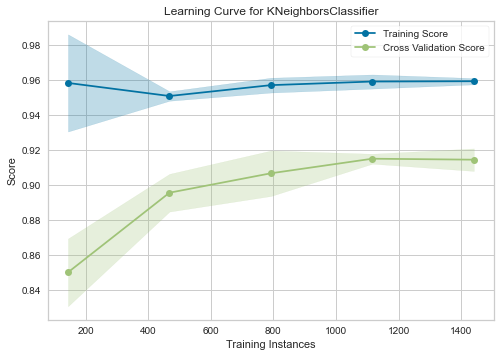

accuracy: 0.920%


In [41]:
clf = KNeighborsClassifier(3)
# Create the learning curve visualizer
visualizer = LearningCurve(
    clf
)

visualizer.fit(x_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

clf.fit(x_train,y_train)
accuracy = clf.score(x_test,y_test)

print("accuracy: {0:.3f}%".format(accuracy))